<a href="https://colab.research.google.com/github/RizkyFadhila123/2025_PBO_TI1A/blob/main/Jobsheet3_viskom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Praktikum D1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

def make_sample(img_size=64, min_r=5, max_r=20):
  r = np.random.randint(min_r, max_r+1)
  img = np.zeros((img_size, img_size)) # Removed the trailing comma
  cx = np.random.randint(r, img_size-r)
  cy = np.random.randint(r, img_size-r)
  cv2.circle(img, (cx, cy), r, 255, -1)
  img = (img / 255.0).astype(np.float32)
  img3 = np.stack([img, img, img], axis=-1)
  return img3, float(r), (cx, cy) # Corrected the return type of radius to float

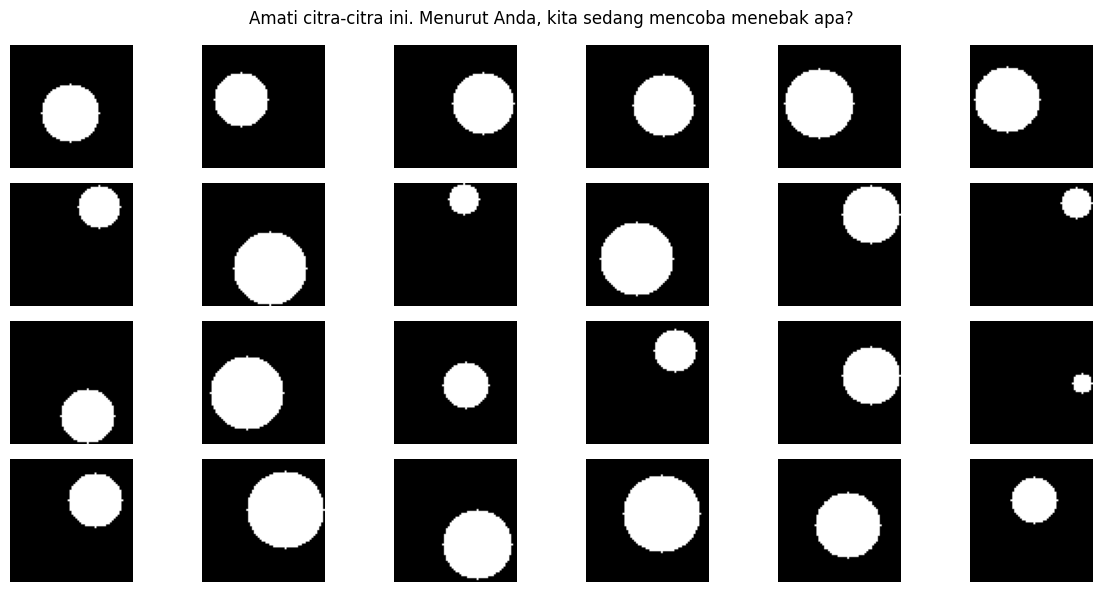

In [ ]:
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()

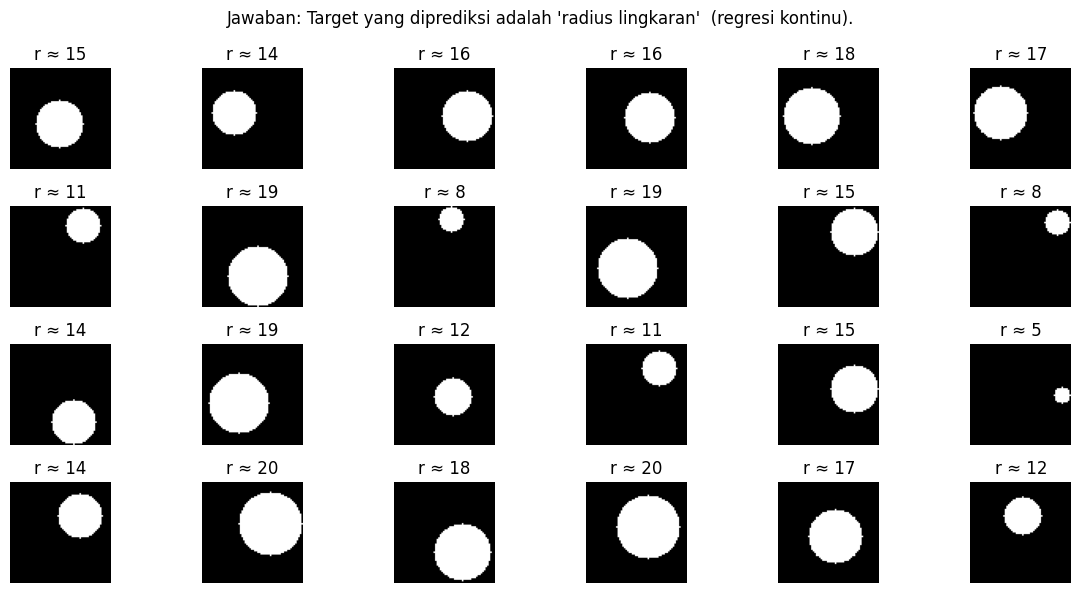

In [ ]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(f"r ≈ {int(rads[i])}")
    plt.axis('off')
plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran'  (regresi kontinu).")
plt.tight_layout()
plt.show()

## Opsional

In [ ]:
# Siapkan dataset lebih besar untuk training N = 3000
N = 3000 # Define N
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1) # output regresi
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),
                    epochs=12, batch_size=64, verbose=0)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
MAE=0.969 | RMSE=1.178 | R²=0.937


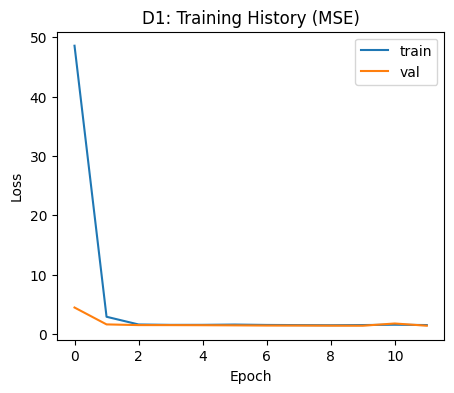

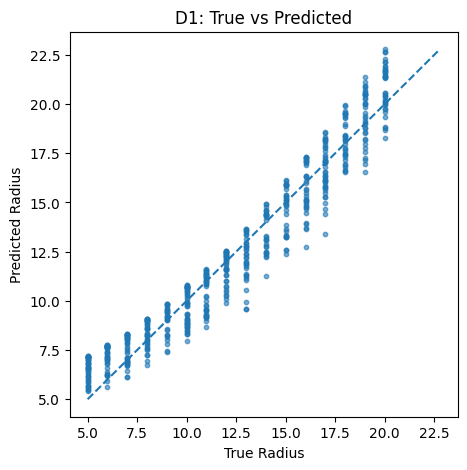

In [ ]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()
# Scatter True vs Pred
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

## Praktikum D2

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rizkyfadhila","key":"f7e12d6f11e64db44d39e069f2c4b719"}'}

In [ ]:
import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("❌ kaggle.json belum ditemukan.")


✅ Kaggle API siap digunakan.


In [ ]:
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


Total gambar ditemukan: 23708


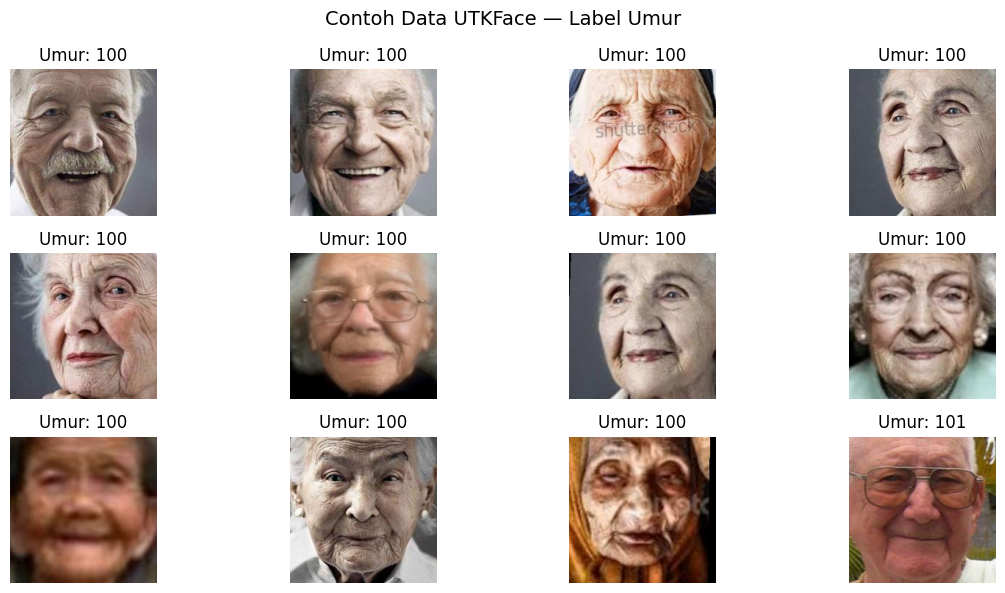

In [ ]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")
plt.suptitle("Contoh Data UTKFace — Label Umur", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(files, ages, test_size=0.2, random_state=42)

IMG_SIZE = 160
def load_img(fp, label):
    img = tf.io.read_file(fp)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds  = tf.data.Dataset.from_tensor_slices((test_files,  y_test)).map(load_img).batch(64)

print("✅ Dataset siap digunakan.")

✅ Dataset siap digunakan.


In [ ]:
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

base_model = tf.keras.applications.MobileNetV2(
    include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 61s 136ms/step - loss: 353.0964 - mae: 13.8028 - val_loss: 159.4183 - val_mae: 9.5953 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 155.2858 - mae: 9.2659 - val_loss: 147.3781 - val_mae: 9.1321 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 145.4853 - mae: 8.8731 - val_loss: 140.7502 - val_mae: 8.8466 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - loss: 142.8878 - mae: 8.7820 - val_loss: 138.7337 - val_mae: 8.7063 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 138.5617 - mae: 8.6360 - val_loss: 139.9067 - val_mae: 8.7809 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 135.2902 - mae: 8.5346 - val_loss: 137.1192 - val_mae: 8.6954 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 136.2420 - mae: 8.4909 - val_loss: 135.7406 - va

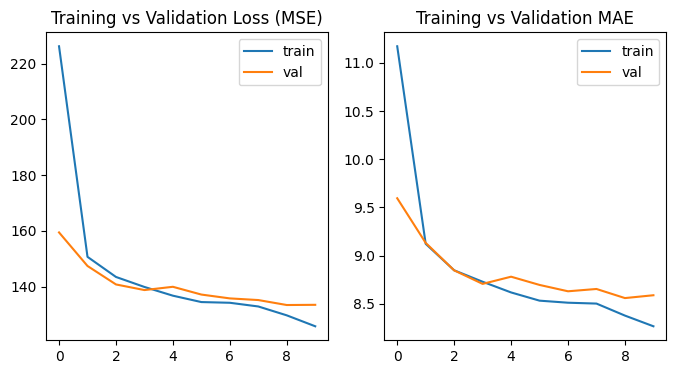

In [ ]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(train_ds, validation_data=test_ds, epochs=10, callbacks=cb, verbose=1)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Training vs Validation Loss (MSE)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.title("Training vs Validation MAE")
plt.legend()
plt.show()

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])
history_ft = model.fit(train_ds, validation_data=test_ds, epochs=5, callbacks=cb, verbose=1)

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 45s 99ms/step - loss: 192.8757 - mae: 10.2712 - val_loss: 137.7212 - val_mae: 8.8281 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 77.3718 - mae: 6.5505 - val_loss: 119.0238 - val_mae: 8.1632 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 52.0583 - mae: 5.4389 - val_loss: 114.2511 - val_mae: 7.8654 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - loss: 37.1068 - mae: 4.6266 - val_loss: 105.2562 - val_mae: 7.4161 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - loss: 28.7864 - mae: 4.0834 - val_loss: 134.1717 - val_mae: 8.3781 - learning_rate: 1.0000e-04


MAE  = 7.42 tahun
RMSE = 10.26 tahun
R²   = 0.735


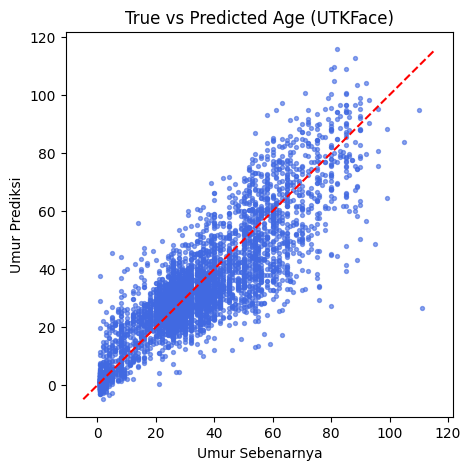

In [ ]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae  = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2   = r2_score(y_test, y_pred)

print(f"MAE  = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R²   = {r2:.3f}")

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.show()

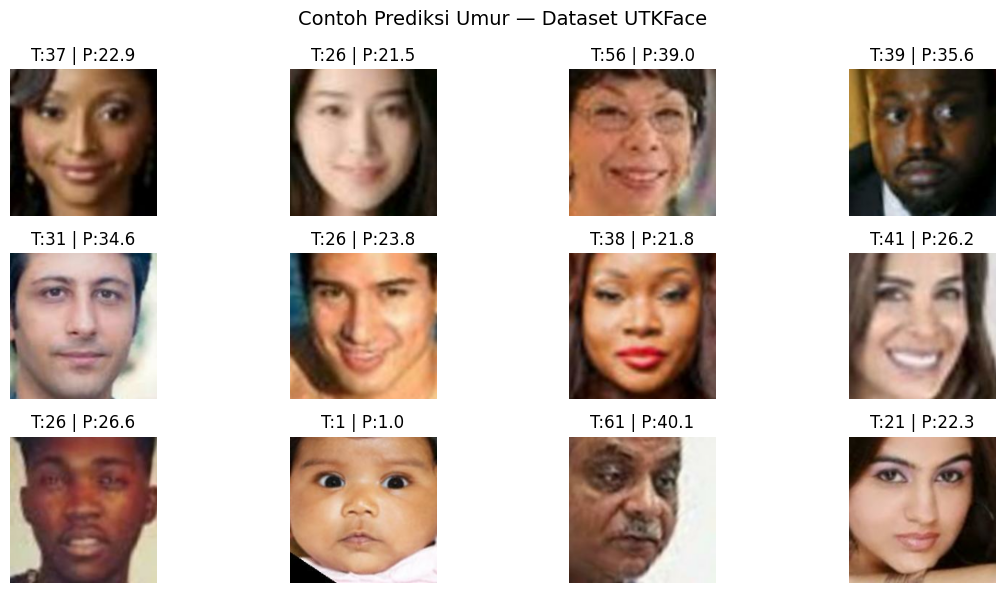

In [ ]:
import random
sample_paths = random.sample(test_files, 12)
plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    true_age = int(os.path.basename(path).split('_')[0])
    pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
    plt.subplot(3,4,i+1)
    plt.imshow(img.numpy())
    plt.title(f"T:{true_age} | P:{pred_age:.1f}")
    plt.axis('off')
plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

## Menggunakan Foto sendiri

Saving ronaldo.jpg to ronaldo (2).jpg


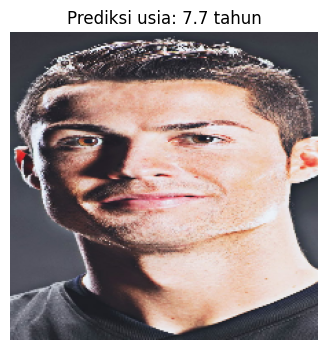

In [ ]:
from google.colab import files
import tensorflow as tf
import matplotlib.pyplot as plt

IMG_SIZE = 224  # coba ukuran lebih besar

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]

plt.figure(figsize=(4,4))
plt.imshow(img.numpy())
plt.title(f"Prediksi usia: {pred_age:.1f} tahun")
plt.axis('off')
plt.show()


## Praktikum D3

In [ ]:
from google.colab import files
files.upload()  # pilih kaggle.json dari komputer Anda
import os, shutil
if os.path.exists("kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    !pip -q install kaggle
    print("✅ Kaggle API siap digunakan.")
else:
    print("    kaggle.json belum ditemukan. Upload terlebih dahulu.")

Saving kaggle.json to kaggle (1).json
✅ Kaggle API siap digunakan.


In [ ]:
# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")

✅ Dataset Pawpularity berhasil diekstrak.


                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

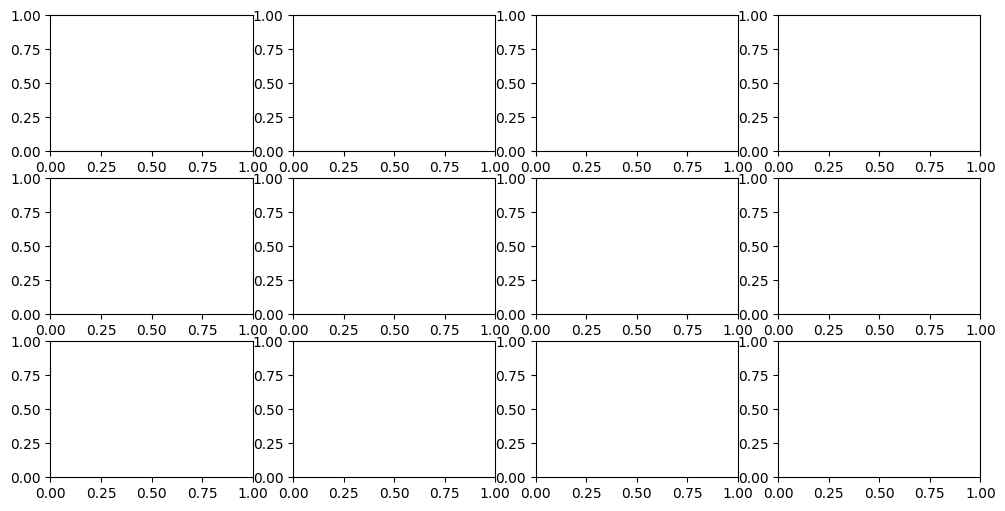

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
    img = Image.open(row.path)
    plt.subplot(3, 4, i + 1)


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'],
train_df['Pawpularity'])).map(load_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'],
val_df['Pawpularity'])).map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(64).prefetch(tf.data.AUTOTUNE)

print(f"Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")

Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


In [ ]:
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False  # freeze sementara

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3,
restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=10,
callbacks=cb, verbose=1)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 104s 507ms/step - loss: 862.4578 - mae: 22.2821 - val_loss: 479.2939 - val_mae: 16.0194 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - loss: 430.9121 - mae: 15.2950 - val_loss: 431.5117 - val_mae: 15.1643 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 42s 237ms/step - loss: 389.3791 - mae: 14.5403 - val_loss: 407.2059 - val_mae: 14.7096 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - loss: 382.0044 - mae: 14.5483 - val_loss: 392.0972 - val_mae: 14.5475 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 41s 236ms/step - loss: 355.8790 - mae: 13.9222 - val_loss: 385.4881 - val_mae: 14.6596 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 208ms/step - loss: 345.9608 - mae: 13.7698 - val_loss: 380.2799 - val_mae: 14.3855 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 202ms/step - loss: 348.8859 - mae: 13.8922 - val_

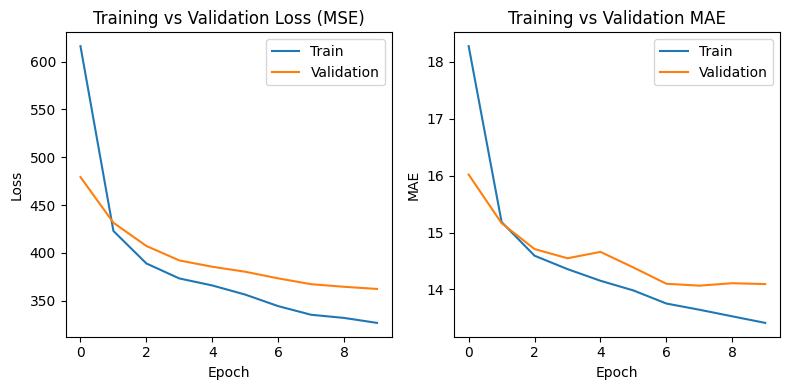

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout()
plt.show()

MAE  = 14.09
RMSE = 19.03
R²   = 0.180


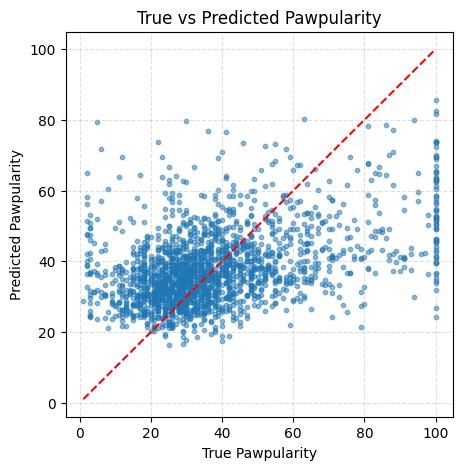

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for
batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.3f}")

# Plot hasil prediksi vs nilai sebenarnya:
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

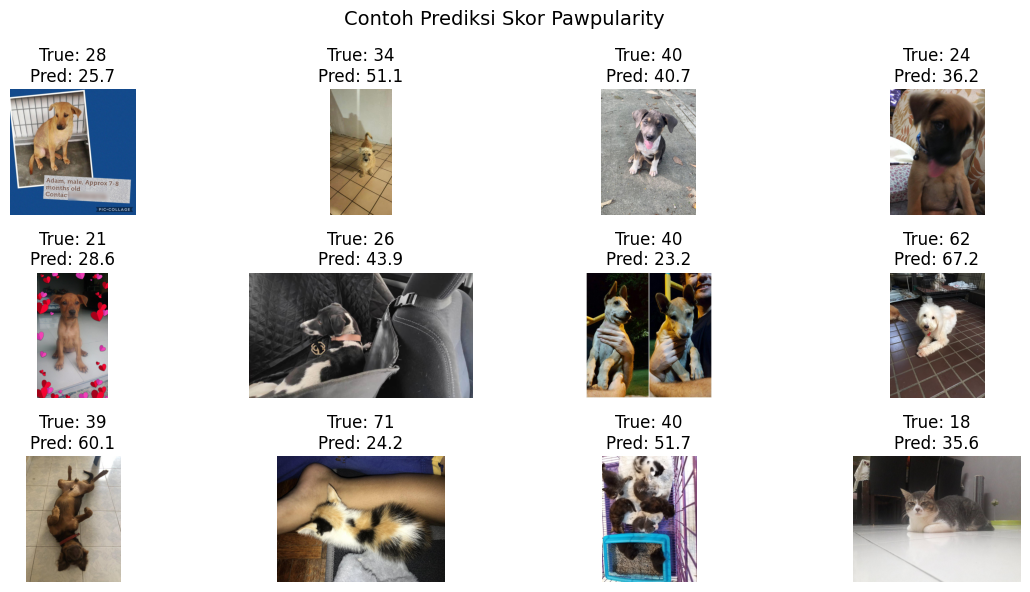

In [ ]:
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12,6))
for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)
    pred = model.predict(tf.expand_dims(load_image(row.path, row.Pawpularity)[0], 0), verbose=0).ravel()[0]
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')
plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

## Menggunakan Foto Hewan sendiri

Saving hewancat.png to hewancat (2).png


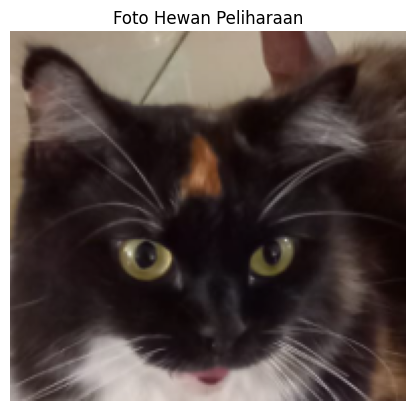

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
💖 Skor Pawpularity: 39.7


In [ ]:
from google.colab import files
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 # Added the import statement for cv2
import numpy as np # Added numpy for np.expand_dims

IMG_SIZE = 224  # coba ukuran lebih besar

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE)) / 255.0

plt.imshow(img_rgb)
plt.title("Foto Hewan Peliharaan")
plt.axis("off")
plt.show()

score = model.predict(np.expand_dims(img_resized, axis=0))[0][0]
print(f"💖 Skor Pawpularity: {score:.1f}")